# MICrONS Explorer

Useful links:<br />
[Matched Cells Functional Data](https://github.com/cajal/microns_phase3_nda/blob/v8/tutorial_notebooks/Matched_Cell_Functional_Data.ipynb)<br />
[DataJoint Introduction](https://github.com/datajoint/microns_phase3_nda/blob/main/tutorial_notebooks/Using_DataJoint_to_Access_Functional_Data.ipynb)<br />
[Dataset Structure](https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/two_photon_processed_data_and_metadata/database_v8/two_photon_processed_data_and_metadata_technical_documentation_v8.pdf)

## Import packages

In [91]:
! pip install datajoint==0.12.9 caveclient==5.7.0 em_coregistration@git+https://github.com/AllenInstitute/em_coregistration@phase3#egg=em_coregistration

  Cloning https://github.com/AllenInstitute/em_coregistration (to revision phase3) to /private/var/folders/g0/db_6133s4c72c83lmc3808m40000gn/T/pip-install-y_ewrjha/em-coregistration_1efe78b85a554d6b9a5ee0cb2b8ea5e1
  Running command git clone --filter=blob:none --quiet https://github.com/AllenInstitute/em_coregistration /private/var/folders/g0/db_6133s4c72c83lmc3808m40000gn/T/pip-install-y_ewrjha/em-coregistration_1efe78b85a554d6b9a5ee0cb2b8ea5e1
  Running command git checkout -b phase3 --track origin/phase3
  Switched to a new branch 'phase3'
  branch 'phase3' set up to track 'origin/phase3'.
  Resolved https://github.com/AllenInstitute/em_coregistration to commit bc40b2ae89523538a5d39afdedaad9e1887cbd68
  Preparing metadata (setup.py) ... done


In [92]:
import datajoint as dj
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

from caveclient import CAVEclient
from dotenv import load_dotenv
from getpass import getpass
from pathlib import Path
from tqdm import tqdm

## Setup environment variables

In [93]:
env_variables = [
  'DJ_HOST',
  'DJ_USER',
  'DJ_PASS',

  'CAVE_TOKEN',
]

load_dotenv()

for key in env_variables:
  value = os.getenv(key)

  if value is None:
    value = getpass(key)

  os.environ[key] = value

## Suppress warnings

In [94]:
warnings.filterwarnings('ignore')

## Define local database credentials

Instructions for using the local database are available at https://github.com/cajal/microns-nda-access.

In [95]:
dj.config['database.host'] = os.getenv('DJ_HOST')
dj.config['database.user'] = os.getenv('DJ_USER')
dj.config['database.password'] = os.getenv('DJ_PASS')
from microns_phase3 import nda, utils

## Define target FPS

In [96]:
target_fps = 15

## Define CAVE token

In [97]:
cave_token = os.getenv('CAVE_TOKEN')
cave_token

'23cb4b93107cded6031110245a86cb9c'

In [98]:
def fetch_coregistration_manual_dataset(version=4):
  dataset_name = f'coregistration_manual_v{version}'
  filename = f'{dataset_name}.csv'

  if os.path.exists(filename):
    return pd.read_csv(filename)
  else:
    client = CAVEclient()
    client.auth.save_token(cave_token, overwrite=True)
    client = CAVEclient('minnie65_public')
    latest_materialize_version = max(client.materialize.get_versions())
    client.materialize.version = latest_materialize_version
    matched_df = client.materialize.query_table('coregistration_manual_v4')
    matched_df.to_csv(filename)
    return matched_df

In [99]:
coregistration_manual_df = fetch_coregistration_manual_dataset()
coregistration_manual_df

,Unnamed: 0,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,0,13337,2024-05-21 18:42:40.725320+00:00,t,582276,7,5,4909,4,6.10722,9.56868,582276,2020-09-28 22:41:42.536121+00:00,t,274.291589,111332012547320963,864691135738685297,[338720 125232 19589],[nan nan nan],[nan nan nan]
1,1,12542,2024-05-21 18:42:40.285576+00:00,t,194144,7,4,9575,6,8.55708,-0.71490,194144,2020-09-28 22:42:01.511773+00:00,t,213.307228,83542405709639148,864691135614842827,[136400 170640 17951],[nan nan nan],[nan nan nan]
2,2,15097,2024-05-21 18:42:41.703496+00:00,t,194144,8,5,8632,6,4.25055,7.87525,194144,2020-09-28 22:42:01.511773+00:00,t,213.307228,83542405709639148,864691135614842827,[136400 170640 17951],[nan nan nan],[nan nan nan]
3,3,12829,2024-05-21 18:42:40.443453+00:00,t,517966,7,5,1526,2,5.82370,4.16608,517966,2020-09-28 22:41:48.288009+00:00,t,313.318932,107530794289274882,864691136966116814,[310944 115888 16752],[nan nan nan],[nan nan nan]
4,4,18299,2024-05-21 18:42:43.440278+00:00,t,293318,9,4,8066,6,5.63758,8.91502,293318,2020-09-28 22:45:23.572432+00:00,t,430.108180,90783515419343652,864691135502985397,[189472 119296 26037],[nan nan nan],[nan nan nan]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19176,19176,14125,2024-05-21 18:42:41.164297+00:00,t,294539,8,5,2740,2,4.80801,0.93167,294539,2020-09-28 22:45:19.090364+00:00,t,367.674819,89659676492660967,864691135938604804,[181216 134624 21266],[nan nan nan],[nan nan nan]
19177,19177,17380,2024-05-21 18:42:42.943521+00:00,t,256736,9,4,2582,2,3.01300,9.97050,256736,2020-09-28 22:45:09.951016+00:00,t,330.874880,88461140300269012,864691135988461315,[172128 117536 22828],[nan nan nan],[nan nan nan]
19178,19178,19051,2024-05-21 18:42:43.850747+00:00,t,422857,9,6,4965,4,7.72988,5.88402,422857,2020-09-28 22:43:49.418248+00:00,t,328.749711,99932345649552731,864691135867970070,[255616 126112 26776],[nan nan nan],[nan nan nan]
19179,19179,1182,2024-05-21 18:38:22.960868+00:00,t,302957,4,7,7908,8,5.59223,8.69387,302957,2020-09-28 22:44:02.400990+00:00,t,507.260273,90020659837046869,864691135585266808,[183456 202752 20953],[nan nan nan],[nan nan nan]


In [100]:
coregistration_manual_df.columns

Index(['Unnamed: 0', 'id', 'created', 'valid', 'target_id', 'session',
       'scan_idx', 'unit_id', 'field', 'residual', 'score', 'id_ref',
       'created_ref', 'valid_ref', 'volume', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [101]:
from scipy import interpolate

def transform_fps(time_series, original_fps, target_fps):
  original_time = np.arange(len(time_series)) / original_fps
  target_time = np.arange(len(time_series)) / target_fps
  interpolation_function = interpolate.interp1d(
    original_time,
    time_series,
    kind='linear',
    fill_value='extrapolate',
  )
  interpolated_time_series = interpolation_function(target_time)
  return interpolated_time_series

In [102]:
def parse_pt_position(pt_position):
  result = re.match(r'^\[(\d+)\s+(\d+)\s+(\d+)\]$', pt_position)

  return int(result.group(1)), int(result.group(2)), int(result.group(3))

parse_pt_position('[338720 125232 19589]')

(338720, 125232, 19589)

In [103]:
grouped_df = coregistration_manual_df.groupby(['session', 'scan_idx'])
metadata = []
spacial_stats = {}
preprocessed_dataset_dir = Path('./preprocessed_dataset')

for (session_idx, scan_idx), group_df in tqdm(grouped_df):
  preprocessed_df = pd.DataFrame()
  group_nframes = None

  min_x, min_y, min_z = None, None, None
  max_x, max_y, max_z = None, None, None
  group_spacial_stats = {'coords': {}, 'volumes': {}}

  for index, row in group_df.iterrows():
    unit_id = row['unit_id']
    unit_key = {'session': session_idx, 'scan_idx': scan_idx, 'unit_id': unit_id}
    # fetch number of frames and fps
    nframes, fps = (nda.Scan & unit_key).fetch1('nframes', 'fps')
    # fetch calcium fluorescence trace
    calcium_trace = (nda.ScanUnit * nda.Fluorescence & unit_key).fetch1('trace')
    calcium_trace = transform_fps(calcium_trace, fps, target_fps)
    # replace negative values with zero values
    calcium_trace = np.where(calcium_trace < 0, 0, calcium_trace)
    preprocessed_df[unit_id] = calcium_trace

    x, y, z = parse_pt_position(row['pt_position'])
    group_spacial_stats['coords'][unit_id] = [x, y, z]
    group_spacial_stats['volumes'][unit_id] = float(row['volume'])

    if min_x is None or x < min_x:
      min_x = x
    if min_y is None or y < min_y:
      min_y = y
    if min_z is None or z < min_z:
      min_z = z

    if max_x is None or x > max_x:
      max_x = x
    if max_y is None or y > max_y:
      max_y = y
    if max_z is None or z > max_z:
      max_z = z

    if group_nframes is None:
      group_nframes = nframes

  filename = f'session_{session_idx}_scan_{scan_idx}_fps_{target_fps}.csv'
  preprocessed_df.to_csv(preprocessed_dataset_dir / filename)

  group_spacial_stats['min_x'] = min_x
  group_spacial_stats['min_y'] = min_y
  group_spacial_stats['min_z'] = min_z
  group_spacial_stats['max_x'] = max_x
  group_spacial_stats['max_y'] = max_y
  group_spacial_stats['max_z'] = max_z

  spacial_stats[filename] = group_spacial_stats

  group_metadata = {
    'session_idx': int(session_idx),
    'scan_idx': int(scan_idx),
    'frames': int(group_nframes),
    'fps': target_fps,
    'neurons': len(group_df),
    'file': filename,
  }
  metadata.append(group_metadata)

  with open(preprocessed_dataset_dir / 'meta.json', 'w') as f:
    json.dump(metadata, f, indent=4)

  with open(preprocessed_dataset_dir / 'spacial_stats.json', 'w') as f:
    json.dump(spacial_stats, f, indent=4)

100%|██████████| 16/16 [23:25<00:00, 87.83s/it]


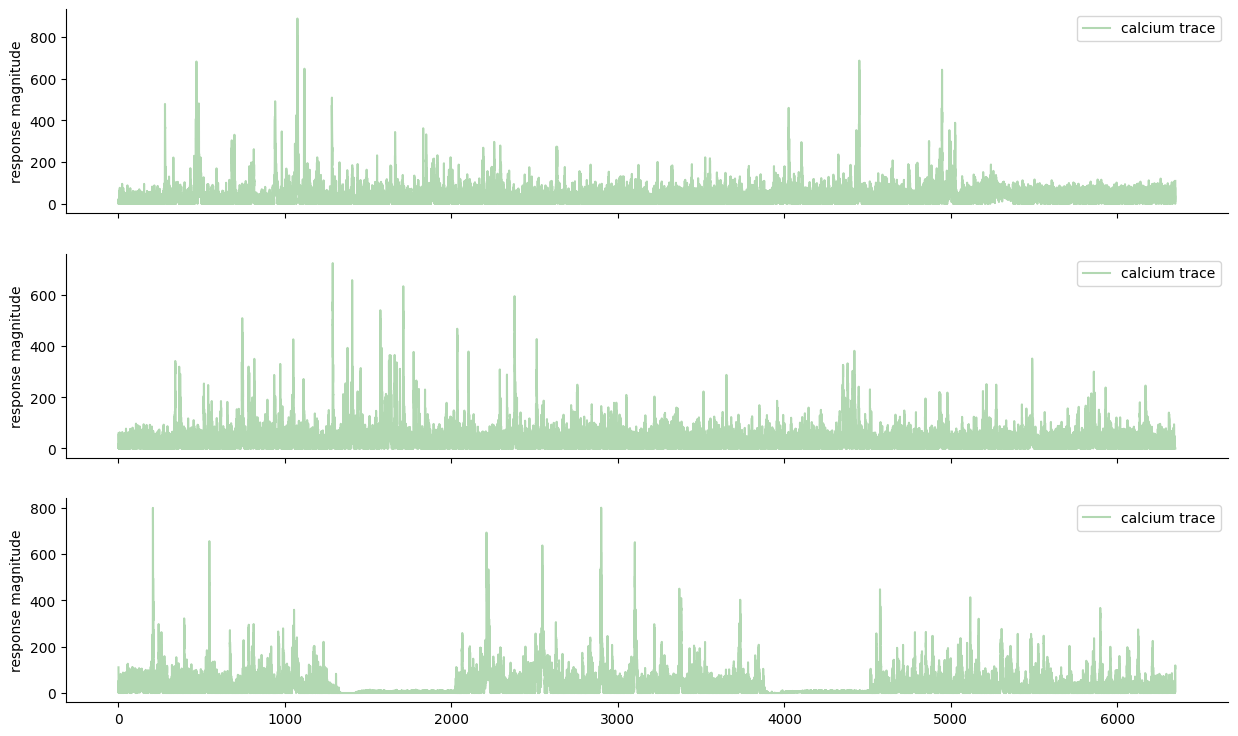

In [104]:
df = pd.read_csv('microns_explorer_sample.csv')
grouped_df = df.groupby(['unit_id', 'session_idx', 'scan_idx'])

fig, axes = plt.subplots(len(grouped_df), 1, figsize=(15, len(grouped_df) * 3), sharex=True)
index = 0
for name, group in grouped_df:
  axis = axes[index]

  axis.plot(group['ts'], group['calcium_trace'], color='g', alpha=0.3, label='calcium trace')
  axis.set_ylabel('response magnitude')
  axis.legend()
  axis.spines['right'].set_visible(False)
  axis.spines['top'].set_visible(False)

  index += 1

plt.show()